# SNV Frequency Spectrum (SFS)

**Author**: Katarina Braun 

## Overview
This notebook plots SNV frequency spectrums. It pulls SNVs and their frequencies from the `-cleaned.csv` files that were generated in the `SNVs.ipynb` script. 

## Dependencies 
- pandas
- numpy
- matplotlib
- glob
- os
- functools
- pandas
- itertools
- glob
- os
- sklearn 

### A useful description regarding the interpretation of these analyses 
**From Moncla et al, 2019, bioRxiv (https://doi.org/10.1101/683151):**  
"Purifying selection removes new variants from the population, generating an excess of low-freq variants, while positive selection promotes accumulation of high-frequency polymorphisms. Exponential population expansion also causes excess low-frequency variation; however, while selection disproportionately affects nonsynonymous variants, demographic factors affect synonymous and nonsynonymous variants equally."

**The figure will look something like this**: 
- Y = proportion of SNVs
- X = within-host SNV frequency bins: 1-10%, 10-20%, 20-30%, 30-40%, 40-50%

I will also try to derive the "neutral expectation" -- that is the distribution of SNPs expected for a given population assuming that the population is not under selection and is at some sort of steady-state equilibrium. 

For the neutral expectation, Trevor Bedford suggests this will follow a 1/x distribution. I can then just integrate over a 1/x distribution between each bin size (0.01 to 0.1, 0.1 to 0.2, etc...). Then I'll calculate the proportion of the total that fall into each bin. Dr. Louise Moncla (cited above) already prepared a notebook to do this: `neutral-expectation.ipynb`, which I am going to utilize here. 
    
## Input: 

`VCFs_Illumina/cleaned/*`

## Output: 

`SFS.pdf`

## import modules and dependecies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import cycle, islice
import random 
from pylab import *
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec

## Add in neutral expectation as a light grey bar

The neutral expectation code is from Dr. Louise Moncla (https://github.com/lmoncla). 

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value.

In [2]:
# define functions 

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [3]:
# predict neutral expectations for 10 bins 
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-99%"],"expected":proportions})
neutral_df.set_index('bin', inplace=True)
neutral_df.rename(columns={'expected':'neutral expectation'}, inplace=True)

## Define non-neutral functions 

In [4]:
def load_Illumina_SNVs(sample): 
    i = pd.read_csv('../../data_derived/figure3_SNVs/VCFs_Illumina/cleaned/' + sample + '-cleaned.csv', sep='\t')
    # modify the dataframes to retain only SNP and frequency 
    # drop any rows with SNPs between 99 and 100% frequency
    i = i[['SNP', '% of population']]
    i = i[~(i['% of population'] >= 99) & (i['% of population'] <= 100)]
    # sort SNPs by frequency 
    i = i.sort_values(by=['% of population'], ascending=False)
    # drop the SNP column and keep frequency only, identity of the SNP doesn't matter for this 
    i = i[['% of population']]
    # determine the number of SNPs so I can determine proportions
    i_num_snps = len(i.index)
    # count the number of SNPs within frequency bins 
    # bins: 1-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-99
    i_SFS = i.apply(pd.Series.value_counts, bins=[1,10,20,30,40,50,60,70,80,90,99])
    # replace counts with proportions 
    i_SFS['proportion of SNVs'] = i_SFS['% of population'].div(i_num_snps)
    i_SFS = i_SFS[['proportion of SNVs']]
    i_SFS = i_SFS.sort_index(ascending=True)
    i_SFS_new = i_SFS.reset_index()
    i_SFS_new = i_SFS_new.rename(index={0:'1-10%', 1:'10-20%', 2:'20-30%', 3:'30-40%', 4:'40-50%', 5:'50-60%', 6:'60-70%', 7:'70-80%', 8:'80-90%', 9:'90-99%'})
    i_SFS_new = i_SFS_new[['proportion of SNVs']]
    i_SFS_new.rename(columns={'proportion of SNVs':'index'}, inplace=True)
    return(i_SFS_new)

def load_ONT_SNVs(sample): 
    i = pd.read_csv('../../data_derived/figure3_SNVs/VCFs_ONT/cleaned/' + sample + '-cleaned.csv', sep='\t')
    # modify the dataframes to retain only SNP and frequency 
    # drop any rows with SNPs between 99 and 100% frequency
    i = i[['SNP', '% of population']]
    i = i[~(i['% of population'] >= 99) & (i['% of population'] <= 100)]
    # sort SNPs by frequency 
    i = i.sort_values(by=['% of population'], ascending=False)
    # drop the SNP column and keep frequency only, identity of the SNP doesn't matter for this 
    i = i[['% of population']]
    # determine the number of SNPs so I can determine proportions
    i_num_snps = len(i.index)
    # count the number of SNPs within frequency bins 
    # bins: 1-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-99
    i_SFS = i.apply(pd.Series.value_counts, bins=[1,10,20,30,40,50,60,70,80,90,99])
    # replace counts with proportions 
    i_SFS['proportion of SNVs'] = i_SFS['% of population'].div(i_num_snps)
    i_SFS = i_SFS[['proportion of SNVs']]
    i_SFS = i_SFS.sort_index(ascending=True)
    i_SFS_new = i_SFS.reset_index()
    i_SFS_new = i_SFS_new.rename(index={0:'1-10%', 1:'10-20%', 2:'20-30%', 3:'30-40%', 4:'40-50%', 5:'50-60%', 6:'60-70%', 7:'70-80%', 8:'80-90%', 9:'90-99%'})
    i_SFS_new = i_SFS_new[['proportion of SNVs']]
    i_SFS_new.rename(columns={'proportion of SNVs':'index'}, inplace=True)
    return(i_SFS_new)

In [7]:
# run the above function on all samples
primary_NP_swab_Illumina = load_Illumina_SNVs('primary_NP_swab')
primary_NP_swab_ONT = load_ONT_SNVs('primary_NP_swab')

p1_vero76_Illumina = load_Illumina_SNVs('p1_vero76')
p1_vero76_ONT = load_ONT_SNVs('p1_vero76')

p1_veroE6_Illumina = load_Illumina_SNVs('p1_veroE6')
p1_veroE6_ONT = load_ONT_SNVs('p1_veroE6')

p1_veroSTAT1KO_Illumina = load_Illumina_SNVs('p1_veroSTAT1KO')
p1_veroSTAT1KO_ONT = load_ONT_SNVs('p1_veroSTAT1KO')

p2a_vero76_Illumina = load_Illumina_SNVs('p2a_vero76')
p2a_vero76_ONT = load_ONT_SNVs('p2a_vero76')

p2b_vero76_Illumina = load_Illumina_SNVs('p2b_vero76')
p2b_vero76_ONT = load_ONT_SNVs('p2b_vero76')

## Generate SFS Plots -- primary swab, then P1 samples, then P2 samples

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


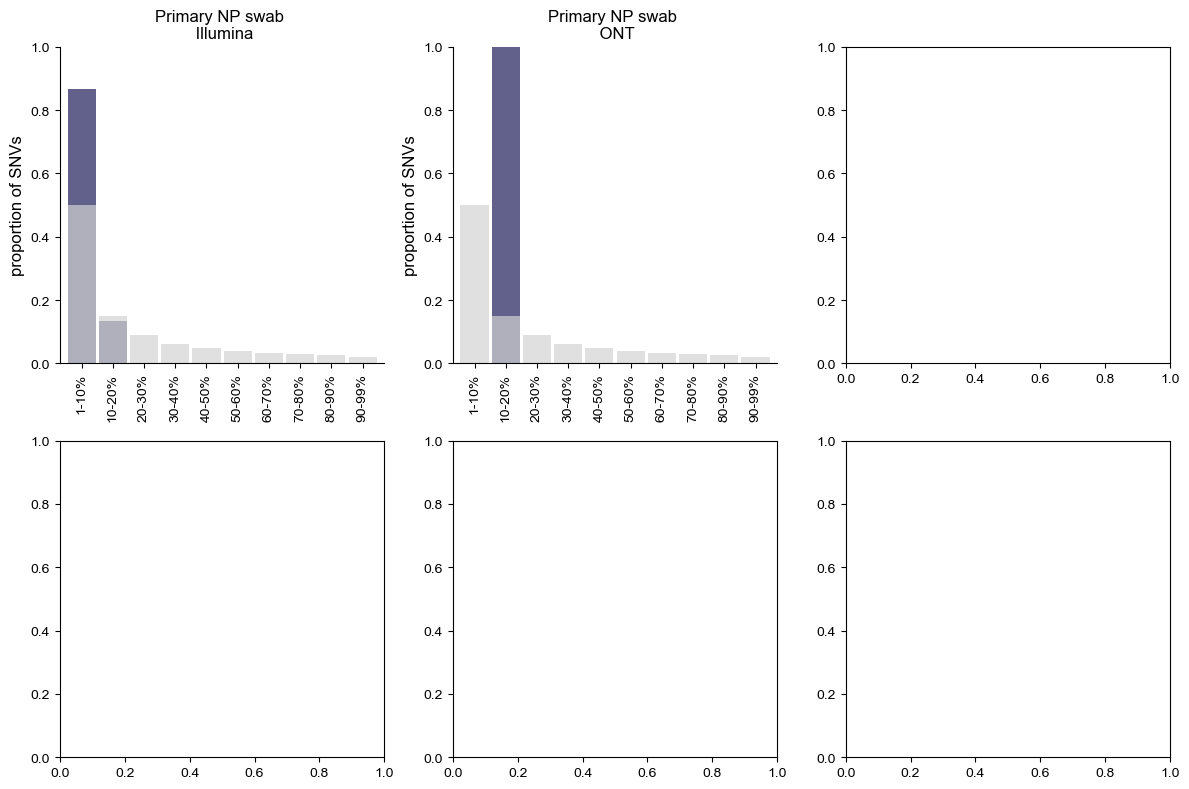

In [18]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(16,16), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 6)

ax1 = fig.add_subplot(gs[0,0:2]) #NP swab Illumina
ax2 = fig.add_subplot(gs[0,2:4]) #NP swab ONT
ax3 = fig.add_subplot(gs[0,4:6]) #P1 veroSTAT1KO Illumina
ax4 = fig.add_subplot(gs[1,0:2]) #P1 vero76 ONT
ax5 = fig.add_subplot(gs[1,2:4]) #P1 veroE6 ONT
ax6 = fig.add_subplot(gs[1,4:6]) #P1 veroSTAT1KO ONT

# get right of top and right frame of each subplot
axes = (ax1, ax2)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# primary_NP_swab_Illumina
color1 = (['#3A3A6E', 'lightgrey'])
primary_NP_swab_Illumina.plot(kind='bar', grid=False, color=color1, figsize=(12,8), width=0.9, alpha=0.8, ax=ax1, legend=False)
ax1.set_title('Primary NP swab \n Illumina', fontname='Arial', fontsize=12)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('', fontname='Arial', fontsize=12)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# primary_NP_swab_ONT
color2 = (['#3A3A6E', 'lightgrey'])
primary_NP_swab_ONT.plot(kind='bar', grid=False, color=color2, figsize=(12,8), width=0.9, alpha=0.8, ax=ax2, legend=False)
ax2.set_title('Primary NP swab \n ONT', fontname='Arial', fontsize=12)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(0,1.0)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax2.set_xlabel('', fontname='Arial', fontsize=12)
ax2.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax1, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax2, legend=False, label=None)

ax1.set_xlabel("")
ax2.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SFS_NP_swabs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


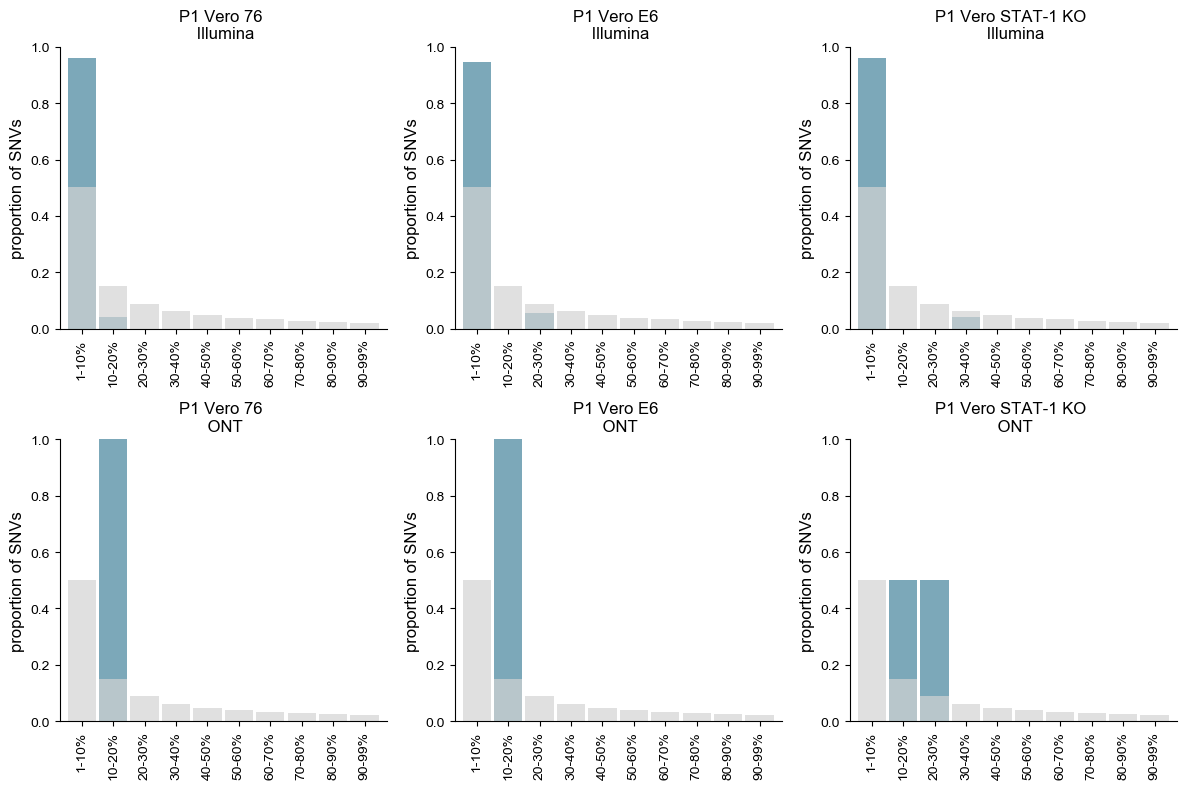

In [16]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(16,16), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 6)

ax7 = fig.add_subplot(gs[0,0:2]) #P1 vero76 Illumina
ax8 = fig.add_subplot(gs[0,2:4]) #P1 veroE6 Illumina
ax9 = fig.add_subplot(gs[0,4:6]) #P1 veroSTAT1KO Illumina
ax10 = fig.add_subplot(gs[1,0:2]) #P1 vero76 ONT
ax11 = fig.add_subplot(gs[1,2:4]) #P1 veroE6 ONT
ax12 = fig.add_subplot(gs[1,4:6]) #P1 veroSTAT1KO ONT

# get right of top and right frame of each subplot
axes = (ax7, ax8, ax9, ax10, ax11, ax12)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# p1_vero76_Illumina
color7 = (['#5B92A8', 'lightgrey'])
p1_vero76_Illumina.plot(kind='bar', grid=False, color=color7, figsize=(12,8), width=0.9, alpha=0.8, ax=ax7, legend=False)
ax7.set_title('P1 Vero 76 \n Illumina', fontname='Arial', fontsize=12)
ax7.set_facecolor('white')
for tick in ax7.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Arial")
ax7.set_ylim(0,1.0)
ax7.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax7.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax7.set_xlabel('', fontname='Arial', fontsize=12)
ax7.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p1_veroE6_Illumina
color8 = (['#5B92A8', 'lightgrey'])
p1_veroE6_Illumina.plot(kind='bar', grid=False, color=color8, figsize=(12,8), width=0.9, alpha=0.8, ax=ax8, legend=False)
ax8.set_title('P1 Vero E6 \n Illumina', fontname='Arial', fontsize=12)
ax8.set_facecolor('white')
for tick in ax8.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Arial")
ax8.set_ylim(0,1.0)
ax8.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax8.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax8.set_xlabel('', fontname='Arial', fontsize=12)
ax8.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p1_veroSTAT1KO_Illumina
color9 = (['#5B92A8', 'lightgrey'])
p1_veroSTAT1KO_Illumina.plot(kind='bar', grid=False, color=color9, figsize=(12,8), width=0.9, alpha=0.8, ax=ax9, legend=False)
ax9.set_title('P1 Vero STAT-1 KO \n Illumina', fontname='Arial', fontsize=12)
ax9.set_facecolor('white')
for tick in ax9.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax9.get_yticklabels():
    tick.set_fontname("Arial")
ax9.set_ylim(0,1.0)
ax9.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax9.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax9.set_xlabel('', fontname='Arial', fontsize=12)
ax9.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p1_vero76_ONT
color10 = (['#5B92A8', 'lightgrey'])
p1_vero76_ONT.plot(kind='bar', grid=False, color=color10, figsize=(12,8), width=0.9, alpha=0.8, ax=ax10, legend=False)
ax10.set_title('P1 Vero 76 \n ONT', fontname='Arial', fontsize=12)
ax10.set_facecolor('white')
for tick in ax10.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax10.get_yticklabels():
    tick.set_fontname("Arial")
ax10.set_ylim(0,1.0)
ax10.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax10.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax10.set_xlabel('', fontname='Arial', fontsize=12)
ax10.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p1_veroE6_ONT
color11 = (['#5B92A8', 'lightgrey'])
p1_veroE6_ONT.plot(kind='bar', grid=False, color=color11, figsize=(12,8), width=0.9, alpha=0.8, ax=ax11, legend=False)
ax11.set_title('P1 Vero E6 \n ONT', fontname='Arial', fontsize=12)
ax11.set_facecolor('white')
for tick in ax11.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax11.get_yticklabels():
    tick.set_fontname("Arial")
ax11.set_ylim(0,1.0)
ax11.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax11.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax11.set_xlabel('', fontname='Arial', fontsize=12)
ax11.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p1_veroSTAT1KO_ONT
color12 = (['#5B92A8', 'lightgrey'])
p1_veroSTAT1KO_ONT.plot(kind='bar', grid=False, color=color12, figsize=(12,8), width=0.9, alpha=0.8, ax=ax12, legend=False)
ax12.set_title('P1 Vero STAT-1 KO \n ONT', fontname='Arial', fontsize=12)
ax12.set_facecolor('white')
for tick in ax12.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax12.get_yticklabels():
    tick.set_fontname("Arial")
ax12.set_ylim(0,1.0)
ax12.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax12.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax12.set_xlabel('', fontname='Arial', fontsize=12)
ax12.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax7, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax8, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax9, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax10, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax11, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax12, legend=False, label=None)

ax7.set_xlabel("")
ax8.set_xlabel("")
ax9.set_xlabel("")
ax10.set_xlabel("")
ax11.set_xlabel("")
ax12.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SFS_P1_samples.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


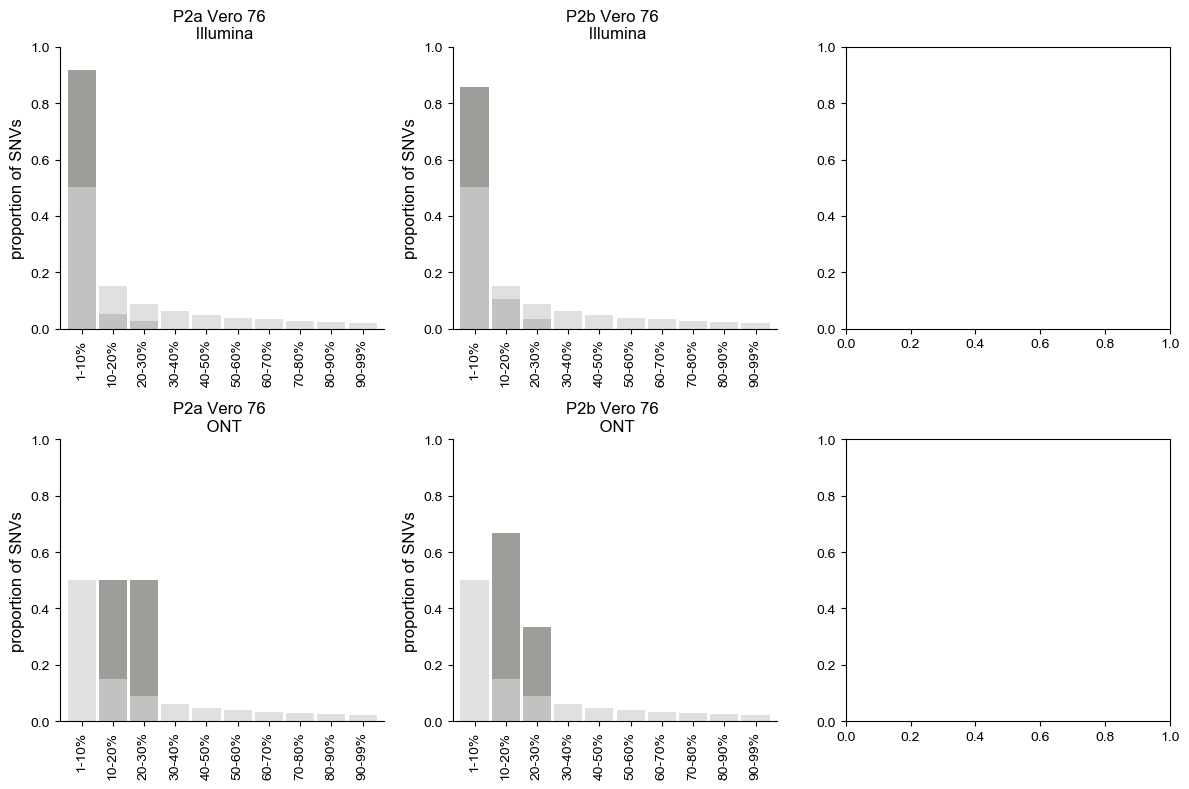

In [19]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(16,16), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 6)

ax15 = fig.add_subplot(gs[0,0:2]) #P2a Illumina
ax16 = fig.add_subplot(gs[0,2:4]) #P2b Illumina
ax17 = fig.add_subplot(gs[1,0:2]) #P2a ONT
ax18 = fig.add_subplot(gs[1,2:4]) #P2b ONT

#empty
ax19 = fig.add_subplot(gs[0,4:6]) 
ax20 = fig.add_subplot(gs[1,4:6])

# get right of top and right frame of each subplot
axes = (ax15, ax16, ax17, ax18)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# p2a_vero76_Illumina
color15 = (['#838681', 'lightgrey'])
p2a_vero76_Illumina.plot(kind='bar', grid=False, color=color15, figsize=(12,8), width=0.9, alpha=0.8, ax=ax15, legend=False)
ax15.set_title('P2a Vero 76 \n Illumina', fontname='Arial', fontsize=12)
ax15.set_facecolor('white')
for tick in ax15.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax15.get_yticklabels():
    tick.set_fontname("Arial")
ax15.set_ylim(0,1.0)
ax15.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax15.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax15.set_xlabel('', fontname='Arial', fontsize=12)
ax15.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
    
# p2b_vero76_Illumina
color16 = (['#838681', 'lightgrey'])
p2b_vero76_Illumina.plot(kind='bar', grid=False, color=color16, figsize=(12,8), width=0.9, alpha=0.8, ax=ax16, legend=False)
ax16.set_title('P2b Vero 76 \n Illumina', fontname='Arial', fontsize=12)
ax16.set_facecolor('white')
for tick in ax16.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax16.get_yticklabels():
    tick.set_fontname("Arial")
ax16.set_ylim(0,1.0)
ax16.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax16.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax16.set_xlabel('', fontname='Arial', fontsize=12)
ax16.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# p2a_vero76_ONT
color17 = (['#838681', 'lightgrey'])
p2a_vero76_ONT.plot(kind='bar', grid=False, color=color17, figsize=(12,8), width=0.9, alpha=0.8, ax=ax17, legend=False)
ax17.set_title('P2a Vero 76 \n ONT', fontname='Arial', fontsize=12)
ax17.set_facecolor('white')
for tick in ax17.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax17.get_yticklabels():
    tick.set_fontname("Arial")
ax17.set_ylim(0,1.0)
ax17.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax17.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax17.set_xlabel('', fontname='Arial', fontsize=12)
ax17.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
    
# p2b_vero76_ONT
color18 = (['#838681', 'lightgrey'])
p2b_vero76_ONT.plot(kind='bar', grid=False, color=color18, figsize=(12,8), width=0.9, alpha=0.8, ax=ax18, legend=False)
ax18.set_title('P2b Vero 76 \n ONT', fontname='Arial', fontsize=12)
ax18.set_facecolor('white')
for tick in ax18.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax18.get_yticklabels():
    tick.set_fontname("Arial")
ax18.set_ylim(0,1.0)
ax18.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax18.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax18.set_xlabel('', fontname='Arial', fontsize=12)
ax18.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax15, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax16, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax17, legend=False, label=None)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax18, legend=False, label=None)

ax15.set_xlabel("")
ax16.set_xlabel("")
ax17.set_xlabel("")
ax18.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SFS_P2_samples.pdf", bbox_inches='tight', dpi=300)